In [1]:
import anndata as ad

# PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_single_cell__label_cell_type__processed.h5ad'
PATH = '/home/ec2-user/cell_census/tabula_sapiens__sample_donor_id__label_cell_type.h5ad'

adata = ad.read_h5ad(PATH)

from enformer_pytorch import GenomeIntervalDataset

class MyGenomeIntervalDataset(GenomeIntervalDataset):
    def __init__(self, **kwargs):
        super(MyGenomeIntervalDataset, self).__init__(**kwargs)

    def __getitem__(self, ind):
        item = super().__getitem__(ind)
        label = self.df.row(ind)[4]
        return label, item


import torch
import polars as pl
import zarr
from enformer_pytorch import Enformer
from torch.utils.data import DataLoader
from tqdm import tqdm
import pyfaidx
from pathlib import Path

torch.multiprocessing.freeze_support()

BASE_PT = "/home/ec2-user/enformer"
DEVICE = "cuda:0"

# BASE_PT = "/Users/nsofroniew/Documents/data/multiomics/enformer"
# DEVICE = "cpu"

FASTA_PT = BASE_PT + "/Homo_sapiens.GRCh38.dna.toplevel.fa"
GENE_INTERVALS_PT = BASE_PT + "/Homo_sapiens.GRCh38.genes.bed"
EMBEDDING_PT = BASE_PT + "/Homo_sapiens.GRCh38.genes.enformer_embeddings.zarr"
EMBEDDING_PT_TSS = BASE_PT + "/Homo_sapiens.GRCh38.genes.enformer_embeddings_tss.zarr"
MODEL_PT = "EleutherAI/enformer-official-rough"

def filter_df_fn(df):
    return df.filter(pl.col("column_5").is_in(list(adata.var_names)))

print("Converting fasta file")
pyfaidx.Faidx(FASTA_PT)
print("Fasta file done")

model = Enformer.from_pretrained(MODEL_PT, output_heads=dict(human = 5313), use_checkpointing = False)
model.to(DEVICE)

Converting fasta file
Fasta file done


Some weights of the model checkpoint at EleutherAI/enformer-official-rough were not used when initializing Enformer: ['_heads.mouse.0.weight', '_heads.mouse.0.bias']
- This IS expected if you are initializing Enformer from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Enformer from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Enformer(
  (stem): Sequential(
    (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): Residual(
      (fn): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
    (2): AttentionPool(
      (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
      (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (conv_tower): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): GELU()
        (2): Conv1d(768, 768, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (1): Residual(
        (fn): Sequential(
          (0): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): GELU()
          (2): Conv1d(768, 768, kernel_size=(1,), stri

In [2]:
ds = MyGenomeIntervalDataset(
    bed_file=GENE_INTERVALS_PT,  # bed file - columns 0, 1, 2 must be <chromosome>, <start position>, <end position>
    fasta_file=FASTA_PT,  # path to fasta file
    return_seq_indices=False,  # return nucleotide indices (ACGTN) or one hot encodings
    rc_aug=False,
    filter_df_fn=filter_df_fn,
)
dl = DataLoader(ds, batch_size=2, shuffle=False, num_workers=0) # type: DataLoader

# Create zarr files
SEQ_EMBED_DIM = 896
EMBED_DIM = 3072
NUM_GENES = len(ds)
TSS = int(SEQ_EMBED_DIM // 2)

paths = (Path(EMBEDDING_PT), Path(EMBEDDING_PT_TSS))

In [3]:
ds[181][0]

'ENSG00000007384'

In [4]:
import pandas as pd
import numpy as np

# targets_txt = 'https://raw.githubusercontent.com/calico/basenji/0.5/manuscripts/cross2020/targets_human.txt'
# df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets = pd.read_csv(BASE_PT + '/targets_human.txt')
df_targets.shape  # (5313, 8) With rows match output shape above.
cage_indices = np.where(df_targets['description'].str.startswith('CAGE:'))[0]

In [5]:
# z_embedding_full = zarr.open(
#     EMBEDDING_PT,
#     mode="w",
#     shape=(NUM_GENES, SEQ_EMBED_DIM, EMBED_DIM),
#     chunks=(1, SEQ_EMBED_DIM, EMBED_DIM),
#     dtype='float32',
# )

# z_embedding_tss = zarr.open(
#     EMBEDDING_PT_TSS,
#     mode="w",
#     shape=(NUM_GENES, EMBED_DIM),
#     chunks=(1, EMBED_DIM),
#     dtype='float32',
# )

# index = 0
# for labels, batch in tqdm(dl):
#     # calculate embedding
#     with torch.no_grad():
#         output, embeddings = model(batch.to(DEVICE), return_embeddings=True)
#         embeddings = embeddings.detach().cpu().numpy()

#     tss_embedding = embeddings[:, TSS]

#     # save full and reduced embeddings
#     batch_size = len(embeddings)
#     z_embedding_full[index : index + batch_size] = embeddings
#     z_embedding_tss[index : index + batch_size] = tss_embedding
#     index += batch_size

In [6]:
labels, batch = next(iter(dl))

In [7]:
batch[0, :10, :]

tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [8]:
batch[0, :10, :]

tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [21]:
with torch.no_grad():
    output, embeddings = model(batch.to(DEVICE), return_embeddings=True)
    cage_expression = output['human'][:, :, cage_indices].mean(dim=-1)
    max_inds = torch.argmax(cage_expression, dim=-1)
    batch_size = len(embeddings)
    tss_embedding = embeddings[torch.arange(batch_size), max_inds]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [10]:
max_inds

tensor([523, 853], device='cuda:0')

In [11]:
tss_embedding.shape

torch.Size([2, 3072])

In [12]:
result = embeddings[torch.arange(2), :, max_inds]


In [13]:
result.shape

torch.Size([2, 896])

In [14]:
cage_expression.shape

torch.Size([2, 896])

In [15]:
label, seq = ds[20]

In [16]:
seq

tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]])

In [20]:
with torch.no_grad():
    output, embeddings = model(seq.to(DEVICE), return_embeddings=True)
    cage_expression = output['human'][:, cage_indices].mean(dim=1)
    max_ind = torch.argmax(cage_expression)
    tss_embedding = embeddings[max_ind]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
embeddings.shape

torch.Size([896, 3072])

In [36]:
list(ds.df['column_5'])

['ENSG00000000003',
 'ENSG00000000005',
 'ENSG00000000419',
 'ENSG00000000457',
 'ENSG00000000460',
 'ENSG00000000938',
 'ENSG00000000971',
 'ENSG00000001036',
 'ENSG00000001084',
 'ENSG00000001167',
 'ENSG00000001460',
 'ENSG00000001461',
 'ENSG00000001497',
 'ENSG00000001561',
 'ENSG00000001617',
 'ENSG00000001626',
 'ENSG00000001629',
 'ENSG00000001630',
 'ENSG00000001631',
 'ENSG00000002016',
 'ENSG00000002330',
 'ENSG00000002549',
 'ENSG00000002587',
 'ENSG00000002726',
 'ENSG00000002745',
 'ENSG00000002746',
 'ENSG00000002822',
 'ENSG00000002834',
 'ENSG00000002919',
 'ENSG00000002933',
 'ENSG00000003056',
 'ENSG00000003096',
 'ENSG00000003137',
 'ENSG00000003147',
 'ENSG00000003249',
 'ENSG00000003393',
 'ENSG00000003400',
 'ENSG00000003402',
 'ENSG00000003436',
 'ENSG00000003509',
 'ENSG00000003756',
 'ENSG00000003987',
 'ENSG00000003989',
 'ENSG00000004059',
 'ENSG00000004139',
 'ENSG00000004142',
 'ENSG00000004399',
 'ENSG00000004455',
 'ENSG00000004468',
 'ENSG00000004478',


In [ ]:
max_ind = torch.argmax(cage_expression)

tensor(746, device='cuda:0')

In [ ]:
tss_embedding.shape

torch.Size([3072])

In [16]:
embeddings.shape

torch.Size([2, 896, 3072])

In [17]:
output['human'].shape

torch.Size([2, 896, 5313])

In [18]:
import matplotlib.pyplot as plt

In [1]:
cage_indices

NameError: name 'cage_indices' is not defined

/opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [136,0,0], thread: [96,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [136,0,0], thread: [97,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [136,0,0], thread: [98,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [136,0,0], thread: [99,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator():

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

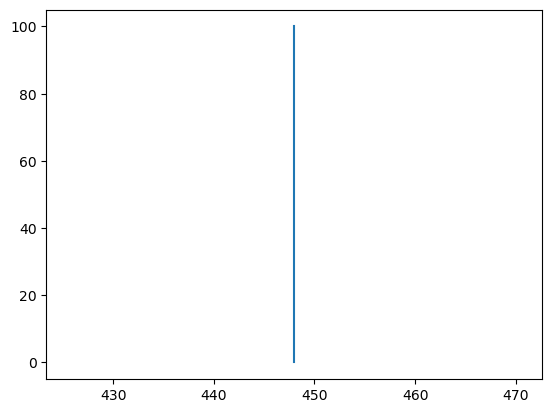

In [19]:
plt.plot([TSS, TSS], [0, 100]);
plt.plot(output['human'][:, cage_indices].mean(dim=1).detach().cpu());

In [194]:
# !pip install pyensembl

In [195]:
# from pyensembl import Genome

# gtf_file_path = BASE_PT + '/Homo_sapiens.GRCh38.77.gtf'

# genome = Genome(reference_name='GRCh38',
#     annotation_name='my_genome_features',
#     gtf_path_or_url=gtf_file_path)
# # genome.index()

In [196]:
label

'ENSG00000002079'

In [26]:
from pyensembl import EnsemblRelease

genome = EnsemblRelease(77)

In [27]:
gene = genome.gene_by_id(label)

# Observed and predicted gene expression values were obtained by summing up the observed/predicted CAGE read counts
# at all unique TSS locations of the gene. For each TSS location, we used the 128-bp bin overlapping the TSS as well
# as the two neighboring bins (3 bins in total).

# For each gene, look through all transcipts - protein coding / not, and record offsets from gene start
gene.transcripts

[Transcript(transcript_id='ENST00000394532', transcript_name='BAD-002', gene_id='ENSG00000002330', biotype='protein_coding', contig='11', start=64269830, end=64284639, strand='-', genome='GRCh38'),
 Transcript(transcript_id='ENST00000309032', transcript_name='BAD-001', gene_id='ENSG00000002330', biotype='protein_coding', contig='11', start=64269834, end=64284669, strand='-', genome='GRCh38'),
 Transcript(transcript_id='ENST00000544785', transcript_name='BAD-008', gene_id='ENSG00000002330', biotype='protein_coding', contig='11', start=64270001, end=64284369, strand='-', genome='GRCh38'),
 Transcript(transcript_id='ENST00000394531', transcript_name='BAD-003', gene_id='ENSG00000002330', biotype='protein_coding', contig='11', start=64270256, end=64284653, strand='-', genome='GRCh38'),
 Transcript(transcript_id='ENST00000493798', transcript_name='BAD-004', gene_id='ENSG00000002330', biotype='protein_coding', contig='11', start=64270269, end=64271868, strand='-', genome='GRCh38'),
 Transcrip

In [48]:
from scipy.ndimage import gaussian_filter1d

def get_tss(gene_id, tss=TSS, length=SEQ_EMBED_DIM, sigma=8):
    gene = genome.gene_by_id(gene_id)
    starts = np.array([tss + np.round((ts.start - gene.start) / 128) for ts in gene.transcripts], dtype=int)
    starts = starts[starts>=0]
    starts = starts[starts<length]
    vector = np.zeros(length)
    vector[starts] = 1.0
    if sigma is not None:
        vector = gaussian_filter1d(vector, sigma)
    return vector

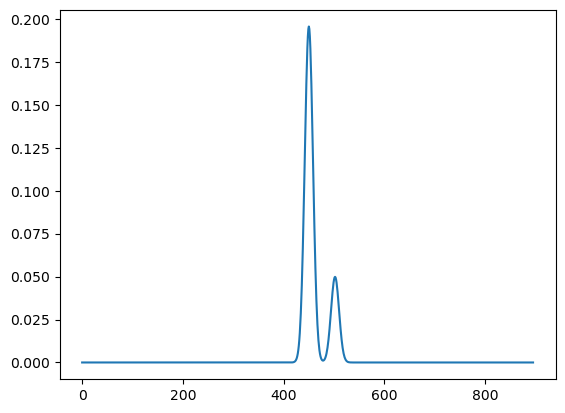

In [49]:
plt.plot(get_tss(label))

In [32]:
def get_tss_locations(genes, tss=TSS):
    locations = {}
    for gene_id in genes:
        gene = genome.gene_by_id(gene_id)
        start_diffs = [tss + np.round((ts.start - gene.start) / 128) for ts in gene.transcripts]
        locations[gene_id] = start_diffs
    return locations

In [37]:
locations = get_tss_locations(list(ds.df['column_5']))

In [38]:
locations

{'ENSG00000000003': [448.0, 460.0, 487.0, 490.0, 497.0],
 'ENSG00000000005': [448.0, 517.0],
 'ENSG00000000419': [448.0, 448.0, 448.0, 448.0, 449.0, 458.0],
 'ENSG00000000457': [448.0, 475.0, 475.0, 486.0, 522.0],
 'ENSG00000000460': [448.0,
  1485.0,
  1487.0,
  1487.0,
  1487.0,
  1488.0,
  1488.0,
  1490.0,
  1494.0],
 'ENSG00000000938': [448.0, 450.0, 450.0, 453.0, 475.0, 536.0, 537.0],
 'ENSG00000000971': [448.0, 449.0, 449.0, 644.0, 1112.0],
 'ENSG00000001036': [448.0, 465.0, 504.0],
 'ENSG00000001084': [448.0,
  448.0,
  448.0,
  454.0,
  459.0,
  470.0,
  510.0,
  536.0,
  570.0,
  580.0,
  580.0,
  581.0,
  644.0],
 'ENSG00000001167': [448.0, 448.0],
 'ENSG00000001460': [448.0,
  448.0,
  448.0,
  448.0,
  539.0,
  542.0,
  622.0,
  715.0,
  716.0,
  718.0,
  792.0,
  900.0],
 'ENSG00000001461': [448.0, 448.0, 448.0, 448.0, 448.0, 448.0, 763.0],
 'ENSG00000001497': [448.0, 448.0, 448.0, 448.0, 509.0],
 'ENSG00000001561': [448.0],
 'ENSG00000001617': [448.0,
  448.0,
  448.0,
 

In [28]:
gene = genome.gene_by_id(label)
start_diffs = [TSS + np.round((ts.start - gene.start) / 128) for ts in gene.transcripts]

In [31]:
start_diffs

[448.0, 448.0, 449.0, 451.0, 451.0, 452.0, 502.0]

(0.0, 20.0)

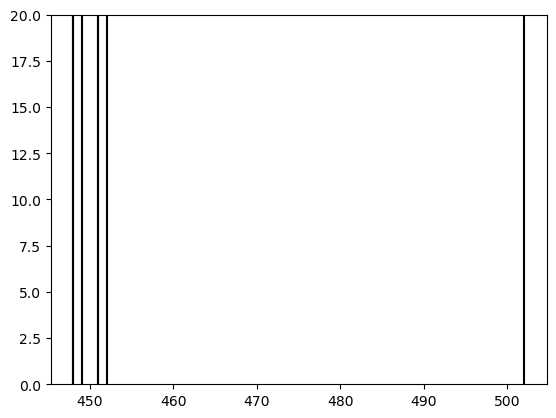

In [30]:
for st in start_diffs:
    plt.plot([st, st], [0, 100], color='k');
# plt.plot(output['human'][:, cage_indices].mean(dim=1).cpu());
plt.ylim([0, 20])

In [200]:
start_diffs

[448.0, 449.0, 600.0, 647.0, 910.0, 922.0, 962.0]